In [271]:
from cairosvg import svg2png
from io import BytesIO
from os import listdir
from PIL import Image
from subprocess import DEVNULL, STDOUT, check_call
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt 
import matplotlib
import numpy as np
import re

In [ ]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [ ]:
def svg_to_image(string, scale=1):
    image = svg2png(bytestring=string, write_to=None, scale=scale)
    return Image.open(BytesIO(image))    

def aspect_fit(image, size=(128, 128)):
    width, height = image.size
    x = (size[0] - width) // 2
    y = (size[1] - height) // 2
    box = (x, y, width + x, height + y)

    background = Image.new("RGB", size, (255, 255, 255))
    background.paste(image, box=box, mask=image.convert("RGBA"))
    return background

In [ ]:
def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    return [atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text)]

In [288]:
def calculate_loss(file, actor="actor.pkl", corner_radius=True, black_and_white=False):
    original = open(file).read().encode('utf-8')
    original_img = svg_to_image(original)    
    scale1 = 128 / max(original_img.size)
    scale2 = 1024 / max(original_img.size)
    
    img = svg_to_image(original, scale=scale1)
    aspect_fit(img, size=(128, 128)).save("input.png", "PNG")
    
    cr = ['--corner_radius'] if corner_radius else []
    file = 'baseline_bw/test.py' if black_and_white else 'baseline/test.py'
    
    check_call(
        ['python3', file, '--max_step=100', '--actor=' + actor, '--img=input.png'] + cr, 
        stdout=DEVNULL, 
        stderr=STDOUT
    )
    
    directory = 'output/'
    
    img_scaled = svg_to_image(original, scale=scale2)
    img_scaled = np.asarray(aspect_fit(img_scaled, size=(1024, 1024)))
    
    svg = open(directory + 'vector_generated249.svg').read().encode('utf-8')
    generated = svg_to_image(svg, scale=8).convert("RGBA")
    
    res = Image.new("RGB", (1024, 1024), (255, 255, 255))
    res.paste(generated, mask=generated)
    res = np.asarray(res)
    
    return mse(res, img_scaled)

#     loss = []
#     for filename in sorted(listdir(directory), key=natural_keys):
#         if not filename.endswith('svg'):
#             continue

#         svg = open(directory + filename).read().encode('utf-8')
#         generated = svg_to_image(svg, scale=8).convert("RGBA")

#         res = Image.new("RGB", (1024, 1024), (255, 255, 255))
#         res.paste(generated, mask=generated)
#         res = np.asarray(res)

#         loss.append(mse(res, img_scaled))
#     return np.array(loss)

In [289]:
logos = listdir('logos/')[:50]

In [276]:
loss = []
for filename in tqdm(logos, desc='dirs'):
    if not filename.endswith('svg'):
        continue
    
    loss.append(calculate_loss('logos/' + filename))

dirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [27:49<00:00, 33.39s/it]


In [277]:
loss_a = []
for filename in tqdm(logos, desc='dirs'):
    if not filename.endswith('svg'):
        continue
    
    loss_a.append(calculate_loss('logos/' + filename, "actor_a.pkl", False))

dirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [28:25<00:00, 34.11s/it]


In [290]:
print(np.mean(loss))
print(np.mean(loss_a))

1237.432013156179
1416.7285468274436


In [292]:
print(np.mean(loss, axis=0)[-1])
print(np.mean(loss_a, axis=0)[-1])

879.5029771041868
1069.098226922353


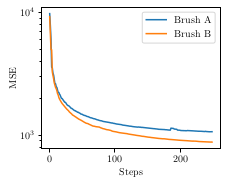

In [281]:
loss1_b = np.array(loss)
loss1_a = np.array(loss_a)

# mean = loss_a.mean(axis=0)
# stdev = np.std(loss, axis=0)

plt.figure(figsize=(3.2, 2.6))

plt.plot(loss1_a.mean(axis=0), label='Brush A')
plt.plot(loss1_b.mean(axis=0), label='Brush B')

plt.legend()
plt.yscale('log')

plt.ylabel("MSE")
plt.xlabel("Steps")
plt.savefig('x_icons.pgf', bbox_inches='tight')
#plt.fill_between(x, mean - stdev, mean + stdev, alpha=0.30)

In [285]:
illustrations_a = []
illustrations_b = []
for filename in tqdm(listdir('illustrations/')[:150], desc='dirs'):
    if not filename.endswith('svg'):
        continue
    
    illustrations_b.append(calculate_loss('illustrations/' + filename))
    illustrations_a.append(calculate_loss('illustrations/' + filename, "actor_a.pkl", False))
    
print("Model A:", np.mean(illustrations_a))
print("Model B:", np.mean(illustrations_b))

dirs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [23:48<00:00,  9.52s/it]

Model A: 2142.696227911357
Model B: 2014.6746721503973


In [293]:
def calculate_loss2(file, actor="actor.pkl", corner_radius=True, black_and_white=False):
    img = Image.open(file)
    img_scaled = Image.open(file.replace(".png", "_scaled.png"))
    img_scaled = np.asarray(img_scaled)
    
    cr = ['--corner_radius'] if corner_radius else []
    pyfile = 'baseline_bw/test.py' if black_and_white else 'baseline/test.py'
    
    check_call(
        ['python3', pyfile, '--max_step=100', '--actor=' + actor, '--img=' + file] + cr, 
            stdout=DEVNULL, 
            stderr=STDOUT
    )
    
    directory = 'output/'
    
#     svg = open(directory + 'vector_generated249.svg').read().encode('utf-8')
#     generated = svg_to_image(svg, scale=8).convert("RGBA")
    
#     res = Image.new("RGB", (1024, 1024), (255, 255, 255))
#     res.paste(generated, mask=generated)
#     res = np.asarray(res)
    
#     return mse(res, img_scaled)

    res = Image.new("RGB", (1024, 1024), (255, 255, 255))
    res = np.asarray(res)

    loss = []
    for filename in sorted(listdir(directory), key=natural_keys):
        if not filename.endswith('svg'):
            continue

        svg = open(directory + filename).read().encode('utf-8')
        generated = svg_to_image(svg, scale=8).convert("RGBA")

        res = Image.new("RGB", (1024, 1024), (255, 255, 255))
        res.paste(generated, mask=generated)
        res = np.asarray(res)

        loss.append(mse(res, img_scaled))
    return np.array(loss)

In [287]:
icons_a = []
icons_b = []
for filename in tqdm(listdir('img_iconator_test/')[:150], desc='dirs'):
    if not filename.endswith('.png') or filename.endswith('_scaled.png'):
        continue
    
    icons_b.append(calculate_loss2('img_iconator_test/' + filename))
    icons_a.append(calculate_loss2('img_iconator_test/' + filename, "actor_a.pkl", False))
    
print("Model A:", np.mean(icons_a))
print("Model B:", np.mean(icons_b))

dirs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [09:58<00:00,  3.99s/it]

Model A: 934.5524839825104
Model B: 863.4535653579637


In [306]:
iconsbw = []
# iconsbw_a = []
# iconsbw_b = []
for filename in tqdm(listdir('bw_iconator_test/')[:50], desc='dirs'):
    if not filename.endswith('.png') or filename.endswith('_scaled.png'):
        continue
    
    iconsbw.append(calculate_loss2('bw_iconator_test/' + filename, "actor_bw2.pkl", black_and_white=True))
#     iconsbw_b.append(calculate_loss2('bw_iconator_test/' + filename))
#     iconsbw_a.append(calculate_loss2('bw_iconator_test/' + filename, "actor_a.pkl", False))
    
print("Model:", np.mean(iconsbw))
print("Model A:", np.mean(iconsbw_a))
print("Model B:", np.mean(iconsbw_b))

dirs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [11:23<00:00, 13.67s/it]

Model: 3724.29294391187
Model A: 11758.389385953607
Model B: 11728.489200441996


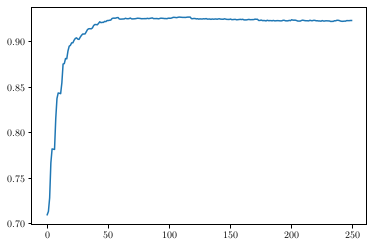

In [262]:
loss = np.array(iconsbw)
plt.plot(loss.mean(axis=0))
plt.savefig('test1234.pgf', bbox_inches='tight')

Model: 2765.5928934415183
Model A: 890.5338964462279
Model B: 872.7258044746187


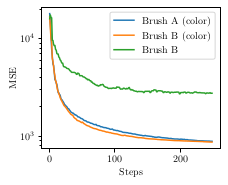

In [307]:
loss_b = np.array(iconsbw_b)[:,:250]
loss_a = np.array(iconsbw_a)[:,:250]
loss = np.array(iconsbw)[:,:250]

print("Model:", loss.mean(axis=0)[-1])
print("Model A:", loss_a.mean(axis=0)[-1])
print("Model B:", loss_b.mean(axis=0)[-1])

# mean = loss_a.mean(axis=0)
# stdev = np.std(loss, axis=0)

plt.figure(figsize=(3.2, 2.6))

plt.plot(loss_a.mean(axis=0), label='Brush A (color)')
plt.plot(loss_b.mean(axis=0), label='Brush B (color)')
plt.plot(loss.mean(axis=0), label='Brush B')

plt.legend()
plt.yscale('log')

plt.ylabel("MSE")
plt.xlabel("Steps")
plt.savefig('icons_bw_mse.pgf', bbox_inches='tight')
#plt.fill_between(x, mean - stdev, mean + stdev, alpha=0.30)

In [ ]:
x = np.linspace(1, 250, 249)

# loss_a = np.array(iconsbw_a)[:,1:]
# loss_b = np.array(iconsbw_b)[:,1:]

plt.figure(figsize=(3.2, 2.6))

# plt.plot(x, loss_a.mean(axis=0), label='Brush A')
# plt.plot(x, loss_b.mean(axis=0), label='Brush B')

plt.legend()

plt.ylabel("MSE")
plt.xlabel("Steps")
plt.savefig('icons_bw.pgf', bbox_inches='tight')

In [ ]:
for x in loss_a[10:16]:
    plt.plot(x)
    
plt.show()

In [ ]:
plt.savefig('histogram.pgf')

In [ ]:
import json

f = open('potrace_color.json', "r")

loss2 = np.array(json.loads(f.read()))
x = np.linspace(3, 32, 29)

plt.figure(figsize=(4.0, 3.2))

plt.plot(x, loss2.mean(axis=0))
plt.ylabel("MSE")
plt.xlabel("$N$ (Number of colors)")
plt.savefig('potrace_color.pgf', bbox_inches='tight')

In [ ]:
k = Image.open("kanker.png").convert('L')
k_scaled = Image.open("k2.png").convert('L')

k = np.asarray(k)
k_scaled = np.asarray(k_scaled)
((k - k_scaled) ** 2).mean()

In [ ]:
empty = Image.new("L", (1024, 1024), 255)
empty = np.asarray(empty)

((empty - k_scaled) ** 2).mean()